<a href="https://colab.research.google.com/github/usamabaig1/twitter_sentiment_reach/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(123)
import re as re


In [2]:
#installing tweet-preprocessor
!pip install tweet-preprocessor

In [3]:
tweetsdf  = pd.read_csv('Filtered_data_test.csv', encoding='latin-1')
len(tweetsdf)

9184

# Data Cleaning


In [ ]:
tweetsdf['hashtag'] = tweetsdf['content'].apply(lambda x: re.findall(r'#(\w+)', x))
# print(hashtags[0:5])
# len(hashtags)

In [ ]:
import preprocessor as p

# removal of URLs, Mentions
#forming a separate feature for cleaned tweets
for i,v in enumerate(tweetsdf['content']):
  tweetsdf.loc[i,'text'] = p.clean(v)
  

In [9]:
# import preprocessor as p

# # removal of URLs, Mentions
# #forming a separate feature for cleaned tweets
# for i,v in enumerate(tweetsdf['text']):
#   tweetsdf.loc[i,'text'] = p.remove_twitter_reserved_words(v)

AttributeError: ignored

In [ ]:
#removing null values
tweetsdf = tweetsdf[-(tweetsdf['text'] == "b' '")]

In [ ]:
# tweetsdf[tweetsdf.duplicated(subset = ["text", 'username'])]

In [ ]:
#Duplicate tweets from same user are removed from the dataset to eliminate bias
#Duplicate tweets from different users are left in the dataset
tweetsdf.drop_duplicates(subset =["text", 'username'], 
                     keep = False, inplace = True) 
len(tweetsdf)
# tweetsdf.head()

9371

# Encryption


In [ ]:
!pip install cryptography

In [ ]:
from cryptography.fernet import Fernet

def generate_key():
    """
    Generates a key and save it into a file
    """
    key = Fernet.generate_key()
    with open("secret.key", "wb") as key_file:
        key_file.write(key)

def load_key():
    """
    Load the previously generated key
    """
    return open("secret.key", "rb").read()

def encrypt_message(message):
    """
    Encrypts a message
    """
    key = load_key()
    encoded_message = message.encode()
    f = Fernet(key)
    encrypted_message = f.encrypt(encoded_message)
    return encrypted_message


generate_key()
tweetsdf['url'] = tweetsdf['url'].apply(lambda x: encrypt_message(x))
tweetsdf['username'] = tweetsdf['username'].apply(lambda x: encrypt_message(x))
tweetsdf['user'] = tweetsdf['user'].apply(lambda x: encrypt_message(x))
tweetsdf['conversationId'] = tweetsdf['conversationId'].apply(lambda x: str(x))
tweetsdf['conversationId'] = tweetsdf['conversationId'].apply(lambda x: encrypt_message(x))

In [ ]:

def load_key():
    """
    Load the previously generated key
    """
    return open("secret.key", "rb").read()

def decrypt_message(encrypted_message):
    """
    Decrypts an encrypted message
    """
    key = load_key()
    f = Fernet(key)
    decrypted_message = f.decrypt(encrypted_message)
    return decrypted_message.decode()

# decrypt_message(b'gAAAAABesCUIAcM8M-_Ik_-I1-JD0AzLZU8A8-AJITYCp9Mc33JaHMnYmRedtwC8LLcYk9zpTqYSaDaqFUgfz-tcHZ2TQjAgKKnIWJ2ae9GDoea6tw8XeJ4=')

# Export Data

In [ ]:
tweetsdf.to_csv('Encrypted_Cleaned.csv')

In [ ]:
tweetsdf[['date', 'text', 'replyCount', 'retweetCount ', 'likeCount']].to_csv('Filtered_data.csv')

# Sentiment Analysis


In [ ]:
!pip install vaderSentiment

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

tweetsdf['compound'] = 0
tweetsdf['neg'] = 0
tweetsdf['neu'] = 0
tweetsdf['pos'] = 0
analyzer = SentimentIntensityAnalyzer()
tweetsdf['compound'] = tweetsdf['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
tweetsdf['neg'] = tweetsdf['text'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
tweetsdf['neu'] = tweetsdf['text'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
tweetsdf['pos'] = tweetsdf['text'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
# sentence = "The food was great!" 
# vs = analyzer.polarity_scores(sentence)
# vs
# print("{:-<65} {}".format(sentence, str(vs)))

# EDA


In [22]:
!pip install plotly

In [68]:
group_labels = ['replyCount','likeCount']
# tweetsdf.dtypes
# Create distplot with custom bin_size
fig = ff.create_distplot([tweetsdf[c] for c in group_labels], group_labels, bin_size=5)
fig.show()

In [34]:
group_labels = ['neg', 	'neu', 	'pos']

# Create distplot with custom bin_size
fig = ff.create_distplot([tweetsdf[c] for c in group_labels], group_labels, bin_size=.01)
fig.show()

In [35]:
group_labels = ['Compound Sentiment Distribution']
# , 'Group 2', 'Group 3', 'Group 4']

# Create distplot with custom bin_size
fig = ff.create_distplot([tweetsdf['compound']], group_labels, bin_size=.25)
fig.show()

# Cluster Analysis & Classification

In [40]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [43]:
scaler = StandardScaler()

comp = [[tweetsdf.loc[i,'compound' ]] for i in range(len(tweetsdf)) ]
scaled_features = scaler.fit_transform(comp)

In [45]:
kmeans = KMeans(
    init="random",
    n_clusters=5,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(scaled_features)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [46]:
# The lowest SSE value
print ("Lowest SSE:", kmeans.inertia_)
# Final locations of the centroid
print ("locations of the centroid:", kmeans.cluster_centers_)
# The number of iterations required to converge
print ("number of iterations required to converge:", kmeans.n_iter_)
# kmeans.labels_[:5]
tweetsdf['label'] = kmeans.labels_

13024

Lowest SSE: 349.92894399519895
locations of the centroid: [[ 0.0097157 ]
 [-1.86393256]
 [ 1.04576759]
 [-0.89008571]
 [ 2.01534609]]
number of iterations required to converge: 9


array([1, 4, 0, 0, 2], dtype=int32)

In [61]:
#assigning classes based on  obsereved cluster centers
tweetsdf['class'] = 'unassigned'
# HNeg = Highly Negative, 
# Neg = Negative, 
# Neu = Neutral,
# Pos = Positive, 
# HPos = Highly Positive

# create a list of our conditions
conditions = [
    (tweetsdf['label']==1),
    (tweetsdf['label']==3),
    (tweetsdf['label']==0),
    (tweetsdf['label']==2),
    (tweetsdf['label']==4)]

# create a list of the values we want to assign for each condition
values = ['HNeg', 'Neg', 'Neu', 'Pos', 'HPos']

# create a new column and use np.select to assign values to it using our lists as arguments
tweetsdf['class'] = np.select(conditions, values)

# display updated DataFrame
tweetsdf.head()

,Unnamed: 0,date,text,replyCount,retweetCount,likeCount,compound,neg,neu,pos,label,class
0,0,2020-11-28 23:59:24+00:00,"b'""We have the most bizarre circumstance I\'ve...",0,1,0,-0.6590,0.148,0.852,0.000,1,HNeg
1,3,2020-11-28 23:57:53+00:00,"b'Not an anonymous number among the Million, R...",1,3,8,0.7269,0.000,0.679,0.321,4,HPos
2,4,2020-11-28 23:57:45+00:00,"b""Quindi il non \xc3\xa8 stato sufficiente per...",0,0,0,0.0000,0.000,1.000,0.000,0,Neu
3,5,2020-11-28 23:55:04+00:00,"b'Christmas now, funerals/lockdown later.. \n '",0,0,0,0.0000,0.000,1.000,0.000,0,Neu
4,6,2020-11-28 23:54:54+00:00,b'Good guidelines from \xe2\x81\xa6\xe2\x81\xa...,0,0,2,0.2263,0.000,0.944,0.056,2,Pos


Neu     5458
HNeg    1109
Pos     1041
HPos     806
Neg      770
Name: class, dtype: int64


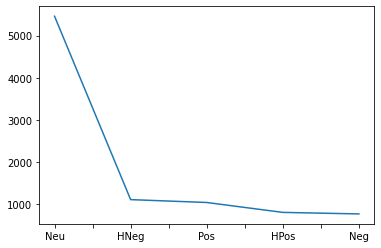

In [65]:
print (tweetsdf['class'].value_counts())
tweetsdf['class'].value_counts().plot()
